In [1]:
import numpy as np
import os
import gym
from gym import spaces
import random
import tensorflow as tf
import math
import matplotlib.pyplot as plt

In [2]:
class spyGameEnv(gym.Env):
  def __init__(self, env_type = 'Deterministic', max_time = 100):
    self.env_type = env_type
    self.env_h = 6
    self.env_w = 6
    self.max_time = max_time
    self.observation_space = spaces.Discrete(self.env_h * self.env_w)
    self.action_space = spaces.Discrete(4)
    self.state = np.zeros((self.env_h, self.env_w))
    self.agent_pos = np.asarray([0, 0])
    self.prev_pos = np.asarray([0, 0])
    self.plus_pos = np.asarray([[5, 1],  [0, 4], [3, 5]])
    self.minus_pos = np.asarray([ [2, 1], [1, 2], [3, 2], [5, 2]])
    self.belle_pos = np.asarray([5, 5])
    self.timestep = 0
    self.reward = 0
    self.done = False
    self.flag = False
    self.agent_choice = ''


  def reset(self):
    self.observation_space = spaces.Discrete(self.env_h * self.env_w)
    self.action_space = spaces.Discrete(4)
    self.state = np.zeros((self.env_h, self.env_w))
    self.state[0, 0] = 1
    self.agent_pos = np.asarray([0, 0])
    self.prev_pos = np.asarray([0, 0])
    self.plus_pos = np.asarray([[5, 1], [0, 4], [3, 5]])
    self.minus_pos = np.asarray([ [2, 1], [1, 2], [3, 2], [5, 2]])
    self.belle_pos = np.asarray([5, 5])
    self.timestep = 0
    self.reward = 0
    self.done = False
    self.flag = False
    self.agent_choice = ''
    flat = self.state.flatten()
    observation = np.where(flat == 1)

    return observation[0]

  def up(self):
    self.agent_choice = 'up'
    if self.agent_pos not in (self.state[-1, :]):
      self.agent_pos[1] -= 1
    
    
  def down(self):
    self.agent_choice = 'down'
    if self.agent_pos not in (self.state[0, :]):
      self.agent_pos[1] += 1
   

  def left(self):
    self.agent_choice = 'left'
    if self.agent_pos not in (self.state[:, 0]):
      self.agent_pos[0] -= 1
   

  def right(self):
    self.agent_choice = 'right'
    if self.agent_pos not in (self.state[:, -1]):
      self.agent_pos[0] += 1
    

  def set_pos(self, action):
    if self.env_type == 'Deterministic':
      if action == 0:
        self.right()
      if action == 1:
        self.left()
      if action == 2:
        self.down()
      if action == 3:
        self.up()

    elif self.env_type == 'Stochastic':
      func = [self.right, self.left, self.down, self.up]
      if action == 0:
        random.choices(func, cum_weights= [70, 80, 90, 100], k = 1)[0]()
      if action == 1:
        random.choices(func, cum_weights= [10, 80, 90, 100], k = 1)[0]()
      if action == 2:
        random.choices(func, cum_weights= [10, 20, 90, 100], k = 1)[0]()
      if action == 3:
        random.choices(func, cum_weights= [10, 20, 30, 100], k = 1)[0]()


  def get_reward(self):

    if self.agent_pos in self.plus_pos:
      self.reward = 0.75
    elif self.agent_pos in self.minus_pos:
      self.reward = -1.5
    elif np.array_equal(self.agent_pos, self.prev_pos):
      self.reward = -0.5
    elif np.array_equal(self.agent_pos, self.belle_pos):
      self.reward = 20
      self.done = True
      self.flag = True
    else:
      self.reward = -0.25

  def step(self, action):
    if not self.done:
      self.reward = 0
      self.prev_pos = self.agent_pos
      self.set_pos(action)
      self.agent_pos = np.clip(self.agent_pos, 0, 5)
      self.get_reward()
      self.timestep += 1
      self.state = np.zeros((self.env_h, self.env_w))
      a = self.agent_pos[0]
      #print(a)
      b = self.agent_pos[1]
      #print(b)
      self.state[a, b] = 1
      #print(self.state)
      flat = self.state.flatten()
      observation = np.where(flat == 1)
      #print(observation)
      if self.timestep == 100:
        self.done = True
      return observation[0], self.reward, self.done, self.flag
       

  def render(self):
    plt.imshow(self.state)
    plt.show()

In [3]:
class ReplayMemory():

  def __init__(self, capacity, observation_shape):

    self.capacity = capacity
    self.dimensions = observation_shape
    self.curr_size = 0

    self.states = np.zeros((capacity, *observation_shape), np.float32)
    self.actions = np.zeros(capacity, np.int32)
    self.rewards = np.zeros(capacity, np.float32)
    self.next_states = np.zeros((capacity, *observation_shape), np.float32)
    self.done = np.zeros(capacity, np.int32)

  def store(self, state, action, reward, next_state, done):

    i = self.curr_size % self.capacity

    #print(self.states)

    self.states[i] = state
    self.actions[i] = action
    self.rewards[i] = reward
    self.next_states[i] = next_state
    self.done[i] = int(not done)

    self.curr_size += i

  def sample(self, size):
    sample_indices = np.random.choice(min(self.capacity, self.curr_size), size, replace = False)

    return (self.states[sample_indices], self.actions[sample_indices], self.rewards[sample_indices], self.next_states[sample_indices], self.done[sample_indices])

In [4]:
class DQNAgent:

  def __init__(self,  lr, state_shape, actions, batch_size, decay_rate = 0.0001, epsilon = 1, gamma = 0.9, buffer_capacity = 1_000_000):
    self.decay_rate = decay_rate
    self.epsilon = epsilon
    self.gamma = gamma
    self.lr = lr
    self.max_eps = 1
    self.min_eps = 0.001
    self.actions = actions
    self.batch_size = batch_size
    self.buffer = ReplayMemory(buffer_capacity, state_shape)
    self.model = self.nn_model()
    self.epsil_track = []
  
  def nn_model(self):
    model = tf.keras.Sequential([tf.keras.layers.Dense(256, activation='relu'),
                                 tf.keras.layers.Dense(256, activation='relu'),
                                 tf.keras.layers.Dense(self.actions, activation=None)])
    optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr)
    model.compile(optimizer=optimizer, loss = 'mean_squared_error')

    return model
  '''
  def map_val(self, a):
    b = ((a + 2.1) / (self.epsilon + 2.1)) * self.epsilon
  
  def get_eps(self, t, ep, a = 0.7, b = 0.5, c = 0.3):
    st_time = (t -a * ep)/(b * ep)
    plac = np.cosh(math.exp(-st_time))
    eps = self.epsilon - (1 / plac + (t * c / ep))
    a = self.map_val(eps)
    b = self.min_eps + (self.max_eps - self.min_eps) * (np.exp(-self.decay_rate * (ep - 1)))
    '''

  def get_action(self, state):
    thresh = np.random.uniform(0, 1)
    if thresh > self.epsilon:
      return np.argmax(self.model.predict(np.array([state])))
    else:
      return np.random.choice(range(self.actions))
  
  def store_exp(self, state, action, reward, next_state, done):
    self.buffer.store(state, action, reward, next_state, done)
  
  def train(self):
    if self.epsilon > self.min_eps:
      self.epsilon -= self.decay_rate
      self.epsil_track.append(self.epsilon)
    else:
      self.epsilon = self.min_eps
      self.epsil_track.append(self.epsilon)
    print(self.epsilon)
    if self.buffer.curr_size >= self.batch_size:
      states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)

      nn_target = np.copy(self.model.predict(states))
      nn_next = self.model.predict(next_states)
      batch = np.arange(self.batch_size, dtype = np.int32)

      nn_target[batch, actions] = rewards + (self.gamma * np.max(nn_next, axis = 1) * dones)
      self.model.train_on_batch(states, nn_target)

      

      

In [5]:
track_ep = []

def run_ops(num_ep, learning_rate, epsilon, gamma):
  env = spyGameEnv()
  agent = DQNAgent(lr = learning_rate, state_shape=env.observation_space.shape, actions = 4, batch_size = 64, epsilon = epsilon, gamma = gamma)
  epsil_all_ep = []
  scores = []
  for i in range(1, num_ep + 1):
    reward_curr_ep = 0
    score = 0
    state = env.reset()
    steps_per_ep = 0
    print('Epsiode', i)
    done = False
    while not done:

      action = agent.get_action(state)
      next_state, reward, done, _ = env.step(action)
      #print(reward)
      score += reward

      agent.store_exp(state, action, reward, next_state, done)
      state = next_state
      agent.train()
      steps_per_ep += 1
      #print("Steps", steps_per_ep)
      #print(agent.epsilon)
      epsil_all_ep.append(agent.epsilon)
    
    
    scores.append(score)

    #print(scores)
  avg_score = np.mean(scores)
  print('Avg Scores =', avg_score)
  min_score = np.min(scores)
  print('Min Score =', min_score)
  max_score = np.max(scores)
  print('Max Score=', max_score)
  plt.plot(scores)
  plt.title('Rewards per Episode')
  track_ep = agent.epsil_track
  
  

Epsiode 1
0.9899
0.9898
0.9897
0.9896
0.9895
0.9894000000000001
0.9893000000000001
0.9892000000000001
0.9891000000000001
0.9890000000000001
0.9889000000000001
0.9888000000000001
0.9887000000000001
0.9886000000000001
0.9885000000000002
0.9884000000000002
0.9883000000000002
0.9882000000000002
0.9881000000000002
0.9880000000000002
0.9879000000000002
0.9878000000000002
0.9877000000000002
0.9876000000000003
0.9875000000000003
0.9874000000000003
0.9873000000000003
0.9872000000000003
0.9871000000000003
0.9870000000000003
0.9869000000000003
0.9868000000000003
0.9867000000000004
0.9866000000000004
0.9865000000000004
0.9864000000000004
0.9863000000000004
0.9862000000000004
0.9861000000000004
0.9860000000000004
0.9859000000000004
0.9858000000000005
0.9857000000000005
0.9856000000000005
0.9855000000000005
0.9854000000000005
0.9853000000000005
0.9852000000000005
0.9851000000000005
0.9850000000000005
0.9849000000000006
0.9848000000000006
0.9847000000000006
0.9846000000000006
0.9845000000000006
0.984

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Streaming output truncated to the last 5000 lines.
0.862600000000014
0.862500000000014
0.862400000000014
0.862300000000014
0.8622000000000141
0.8621000000000141
0.8620000000000141
0.8619000000000141
0.8618000000000141
1/1 [==============================] - 0s 15ms/step
0.8617000000000141
1/1 [==============================] - 0s 16ms/step
0.8616000000000141
0.8615000000000141
0.8614000000000142
0.8613000000000142
0.8612000000000142
0.8611000000000142
0.8610000000000142
0.8609000000000142
0.8608000000000142
0.8607000000000142
0.8606000000000142
0.8605000000000143
0.8604000000000143
0.8603000000000143
0.8602000000000143
1/1 [==============================] - 0s 19ms/step
0.8601000000000143
0.8600000000000143
Epsiode 14
1/1 [==============================] - 0s 18ms/step
0.8599000000000143
1/1 [==============================] - 0s 17ms/step
0.8598000000000143
0.8597000000000143
0.8596000000000144
0.8595000000000144
0.8594000000000144
0.8593000000000144
0.8592000000000144
0.859100000000014

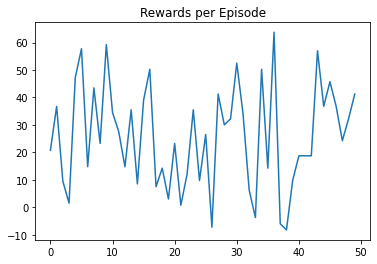

In [6]:
run_ops(50, 0.01, 0.99, 0.95)

In [38]:
from collections import deque
import random
class DQNAgent_cart:

  def __init__(self,  lr, state_shape, actions, batch_size, decay_rate = 0.999, epsilon = 1, gamma = 0.9, buffer_capacity = 1_000_000):
    self.decay_rate = decay_rate
    self.epsilon = epsilon
    self.gamma = gamma
    self.lr = lr
    self.max_eps = 1
    self.min_eps = 0.001
    self.actions = actions
    self.batch_size = batch_size
    self.buffer = deque(maxlen=buffer_capacity)
    self.model = self.nn_model(state_shape)
    self.epsil_track = []
  
  def nn_model(self, state_shape):
    model = tf.keras.Sequential([tf.keras.layers.Dense(256, input_shape =(state_shape, 1), activation='relu'),
                                 tf.keras.layers.Dense(256, activation='relu'),
                                 tf.keras.layers.Dense(self.actions, activation=None)])
    optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr)
    model.compile(optimizer=optimizer, loss = 'mean_squared_error')

    return model
  '''
  def map_val(self, a):
    b = ((a + 2.1) / (self.epsilon + 2.1)) * self.epsilon
  
  def get_eps(self, t, ep, a = 0.7, b = 0.5, c = 0.3):
    st_time = (t -a * ep)/(b * ep)
    plac = np.cosh(math.exp(-st_time))
    eps = self.epsilon - (1 / plac + (t * c / ep))
    a = self.map_val(eps)
    b = self.min_eps + (self.max_eps - self.min_eps) * (np.exp(-self.decay_rate * (ep - 1)))
    '''

  def get_action(self, state):
    thresh = np.random.rand()
    if thresh > self.epsilon:
      return np.argmax(self.model.predict(state)[0])
    else:
      return random.randrange(self.actions)
  
  def store_exp(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))
  
  def train(self):
    if self.epsilon > self.min_eps:
      self.epsilon *= self.decay_rate
      self.epsil_track.append(self.epsilon)
    else:
      self.epsilon = self.min_eps
      self.epsil_track.append(self.epsilon)
    #print(self.epsilon)
    if len(self.buffer) >= self.batch_size:
      batch = []
      for i in range(self.batch_size):
        batch.append(self.buffer.pop())      
      for state, action, reward, next_state, terminal in batch:
        q_update = reward

        if not terminal:
          q_update = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

        q_val = self.model.predict(state)
        q_val[0][action] = q_update
        self.model.fit(state, q_val, verbose =0)
      
      '''
      states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)

      nn_target = np.copy(self.model.predict(states))
      nn_next = self.model.predict(next_states)
      batch = np.arange(self.batch_size, dtype = np.int32)

      nn_target[batch, actions] = rewards + (self.gamma * np.max(nn_next, axis = 1) * dones)
      self.model.train_on_batch(states, nn_target)
      '''

      

      

In [39]:
def run_ops_cart(num_ep, learning_rate, epsilon, gamma):
  env = gym.make("CartPole-v1")
  agent = DQNAgent_cart(lr = learning_rate, state_shape=env.observation_space.shape[0], actions = 2, batch_size = 64, epsilon = epsilon, gamma = gamma)
  epsil_all_ep = []
  scores = []
  for i in range(1, num_ep + 1):
    reward_curr_ep = 0
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, env.observation_space.shape[0]])
    #state = np.reshape(state, [1, env.observation_space.shape])
    steps_per_ep = 0
    print('Epsiode', i)
    done = False
    while not done:

      action = agent.get_action(state)
      if action > 1:
        action = 1
      print("action", action)
      next_state, reward, done, _= env.step(action)
      reward = reward if not done else - 1 * reward
      #print(reward)
      #next_state = np.reshape(next_state, [1, env.observation_space.shape])
      score += reward
      next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
      agent.store_exp(state, action, reward, next_state, done)
      state = next_state
      agent.train()
      steps_per_ep += 1
      print("Steps", steps_per_ep)
      #print(agent.epsilon)
      epsil_all_ep.append(agent.epsilon)
    
    
    scores.append(score)

    #print(scores)
  avg_score = np.mean(scores)
  print('Avg Scores =', avg_score)
  min_score = np.min(scores)
  print('Min Score =', min_score)
  max_score = np.max(scores)
  print('Max Score=', max_score)
  plt.plot(scores)
  plt.title('Rewards per Episode')
  track_ep = agent.epsil_track
  
  

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


Epsiode 1
action 0
Steps 1
action 0
Steps 2
action 0
Steps 3
action 1
Steps 4
action 0
Steps 5
action 1
Steps 6
action 0
Steps 7
action 1
Steps 8
action 0
Steps 9
action 0
Steps 10
action 1
Steps 11
action 0
Steps 12
action 1
Steps 13
Epsiode 2
action 0
Steps 1
action 1
Steps 2
action 0
Steps 3
action 1
Steps 4
action 1
Steps 5
action 1
Steps 6
action 0
Steps 7
action 0
Steps 8
action 1
Steps 9
action 0
Steps 10
action 0
Steps 11
action 1
Steps 12
action 0
Steps 13
action 1
Steps 14
action 0
Steps 15
action 0
Steps 16
action 1
Steps 17
action 0
Steps 18
action 1
Steps 19
action 1
Steps 20
action 0
Steps 21
action 1
Steps 22
action 1
Steps 23
action 0
Steps 24
action 0
Steps 25
action 0
Steps 26
action 1
Steps 27
action 1
Steps 28
action 1
Steps 29
action 0
Steps 30
action 1
Steps 31
action 0
Steps 32
action 0
Steps 33
action 0
Steps 34
action 0
Steps 35
action 0
Steps 36
action 0
Steps 37
action 0
Steps 38
action 0
Steps 39
action 1
Steps 40
action 0
Steps 41
action 1
Steps 42
action 1

1/1 [==============================] - 0s 18ms/step
Steps 51
action 1
Steps 52
action 0
Steps 53
action 0
Steps 54
action 1
Steps 55
action 0
Steps 56
action 0
Steps 57
action 0
Steps 58
action 0
Steps 59
action 0
Steps 60
action 1
Steps 61
1/1 [==============================] - 0s 15ms/step
action 1
Steps 62
action 0
Steps 63
action 0
Steps 64
action 1
Steps 65
action 0
Steps 66
action 1
Steps 67
action 0
Steps 68
action 0
Steps 69
action 1
Steps 70
action 1
Steps 71
action 1
Steps 72
action 1
Steps 73
action 1
Steps 74
action 0
Steps 75
action 0
Steps 76
action 0
Steps 77
action 1
Steps 78
action 0
Steps 79
action 1
Steps 80
Epsiode 3
action 0
Steps 1
action 0
Steps 2
action 0
Steps 3
action 1
Steps 4
action 1
Steps 5
action 0
Steps 6
action 1
Steps 7
1/1 [==============================] - 0s 16ms/step
action 1
Steps 8
action 1
Steps 9
1/1 [==============================] - 0s 18ms/step
action 1
Steps 10
action 0
Steps 11
1/1 [==============================] - 0s 17ms/step
action 1
S

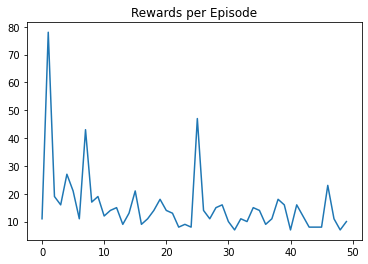

In [40]:
run_ops_cart(50, 0.01, 0.99, 0.95)

In [41]:
def run_ops_car(num_ep, learning_rate, epsilon, gamma):
  env = gym.make("MountainCar-v0")
  agent = DQNAgent_cart(lr = learning_rate, state_shape=env.observation_space.shape[0], actions = 2, batch_size = 64, epsilon = epsilon, gamma = gamma)
  epsil_all_ep = []
  scores = []
  for i in range(1, num_ep + 1):
    reward_curr_ep = 0
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, env.observation_space.shape[0]])
    #state = np.reshape(state, [1, env.observation_space.shape])
    steps_per_ep = 0
    print('Epsiode', i)
    done = False
    while not done:

      action = agent.get_action(state)
      if action > 1:
        action = 1
      print("action", action)
      next_state, reward, done, _= env.step(action)
      reward = reward if not done else - 1 * reward
      #print(reward)
      #next_state = np.reshape(next_state, [1, env.observation_space.shape])
      score += reward
      next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
      agent.store_exp(state, action, reward, next_state, done)
      state = next_state
      agent.train()
      steps_per_ep += 1
      print("Steps", steps_per_ep)
      #print(agent.epsilon)
      epsil_all_ep.append(agent.epsilon)
    
    
    scores.append(score)

    #print(scores)
  avg_score = np.mean(scores)
  print('Avg Scores =', avg_score)
  min_score = np.min(scores)
  print('Min Score =', min_score)
  max_score = np.max(scores)
  print('Max Score=', max_score)
  plt.plot(scores)
  plt.title('Rewards per Episode')
  track_ep = agent.epsil_track
  
  

Epsiode 1
action 0
Steps 1
action 1
Steps 2
action 0
Steps 3
action 0
Steps 4
action 0
Steps 5
action 0
Steps 6
action 1
Steps 7
action 0
Steps 8
action 1
Steps 9
action 0
Steps 10
action 1
Steps 11
action 1
Steps 12
action 1
Steps 13
action 1
Steps 14
action 0
Steps 15
action 0
Steps 16
action 1
Steps 17
action 1
Steps 18
Epsiode 2
action 1
Steps 1
action 0
Steps 2
action 1
Steps 3
action 0
Steps 4
action 0
Steps 5
action 0
Steps 6
action 1
Steps 7
action 0
Steps 8
1/1 [==============================] - 0s 119ms/step
action 1
Steps 9
action 1
Steps 10
action 1
Steps 11
action 0
Steps 12
action 1
Steps 13
action 1
Steps 14
1/1 [==============================] - 0s 15ms/step
action 1
Steps 15
action 0
Steps 16
action 0
Steps 17
action 1
Steps 18
action 1
Steps 19
action 1
Steps 20
action 0
Steps 21
action 0
Steps 22
1/1 [==============================] - 0s 16ms/step
action 0
Steps 23
action 1
Steps 24
Epsiode 3
action 0
Steps 1
action 1
Steps 2
action 0
Steps 3
action 1
Steps 4
action 

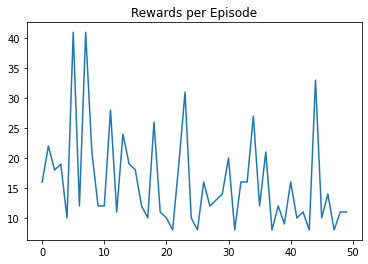

In [42]:
run_ops_cart(50, 0.01, 0.99, 0.95)